In [1]:
# Make maps of ensembles of runs with the same IC for exf variables
# Plots ensemble mean and the anomalies in each run relative to the EM
# Option to select time averaging over all time points or just one year

In [4]:
# from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import Functions_data_analysis as fda
import Functions_plotting as fp
import xarray as xr
import matplotlib.path as mpath
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Datasets import exp_set_dict_warm_order


In [2]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/uwas0134/Gemma/Analysis/Resubmission Figs/Functions_plotting.py'>

In [5]:
# Configure data and plotting options
exp_set = 'ic_2001'
region = 'full_model_domain'

# Times over which to average:
# 'all' selected times or enter int for year avg
# time_mean = 'all'
time_mean = 2001

# How many months of data to retrieve (from the first February of data)
n_months = 12

# Whether to plot in order of warm to cool or westerly to easterly
# runs = exp_set_dict_warm_order[exp_set]
runs = exp_set_dict_warm_order[exp_set]
print('Using the following experiments in this order:\n',runs)

Using the following experiments in this order:
 ['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001', 'run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001', 'run_forc_erai_2015_rep_ic_2001', 'run_forc_erai_2011_rep_ic_2001']


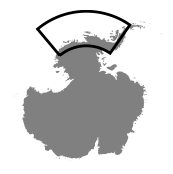

In [6]:
# Plot antarctica map with box over domain 

projection = ccrs.SouthPolarStereo(central_longitude=-100)
fig, ax = plt.subplots(subplot_kw={'projection': projection})
fig.set_size_inches(2,2)
ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='gray')
# ax.coastlines(resolution='110m', color='black')

# -65.5,-76.5,-140,-65.1
lat1,lat2,lon1,lon2 = fda.plot_regions['full_model_domain']

lons_arc = np.linspace(lon1, lon2, 100)
lats_arc = np.full_like(lons_arc, lat2)

# Generate points for the straight line back (at lat1)
lons_back = np.linspace(lon2, lon1, 100)
lats_back = np.full_like(lons_back, lat1)

# Generate points for the left side (from lat1 to lat2 along lon1)
lons_left = np.full_like(lons_arc, lon1)
lats_left = np.linspace(lat1, lat2, 100)

# Combine all points into one path
lons = np.concatenate([lons_arc, lons_back, lons_left])
lats = np.concatenate([lats_arc, lats_back, lats_left])

# Transform the points from (lon, lat) to (x, y) in the polar stereographic projection
vertices_proj = projection.transform_points(ccrs.PlateCarree(), lons, lats)
codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices_proj) - 1)

# Create the Path and PathPatch
path = Path(vertices_proj[:, :2], codes)
patch = PathPatch(path, facecolor='none', edgecolor='black', linewidth=2)

# Add the patch to the axis
ax.add_patch(patch)

# Turn off the axis spines (borders)
for spine in ax.spines.values():
    spine.set_visible(False)

# Hide gridlines and ticks
ax.grid(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#make background clear
# Set the figure background to transparent
fig.patch.set_alpha(0)  # Set the figure background to be transparent

# Set the axis background to transparent
ax.set_facecolor('none')  # Set the axis background to be transparent



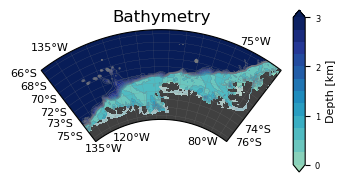

In [5]:
# Plot bathy map to show domain
fp.plot_bathymetry_and_locs(region, [])

In [7]:
# Load datasets as an ensemble 

prefix = 'EXF_forcing_set2' 
all_run_uwind_da = fda.get_ensemble_data_for_ic('uwind', runs, region, prefix, n_months = n_months) 
all_run_vwind_da = fda.get_ensemble_data_for_ic('vwind', runs, region, prefix, n_months = n_months) 

print('Data retrieved!')

Getting uwind data for all runs...
0
saving date from these times for 1st run:
 [cftime.DatetimeNoLeap(2001, 2, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 3, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 4, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 5, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 6, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 7, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 8, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 9, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 10, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 11, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 12, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2002, 1, 1, 0, 0, 0, 0, has_year_zero=True)]
(12, 411, 896)
1
(12, 411, 896)
2
(12, 411, 896)
3
(12, 411, 896)
4
(12, 411, 896)
5
(12, 411, 896)
6
(12, 411, 

In [8]:
# Average data and ensemble mean over the year


# Get averages
uwind_em = all_run_uwind_da.mean(dim = 'run')
uwind_em_time_avg = uwind_em.mean(dim = 'time')
vwind_em = all_run_vwind_da.mean(dim = 'run')
vwind_em_time_avg = vwind_em.mean(dim = 'time')    

In [9]:
# Get ocean temp ensemble data at 400m depth for full 5 years

# Load all 5 years of data
t_fname = '../Saved Arrays/Ensemble_data/T_400m_'+exp_set+'_full_model_domain_60_months.nc'
try:
    t_ds = xr.open_dataset(t_fname) #shape (n_runs, n_times, n_lats, n_lons)
    all_run_T = t_ds.T
    print('precalc T ds found')
except:
    all_run_T = fda.get_ensemble_data_for_ic('T', runs, 'full_model_domain', 'state_3d_set2', month_start_idx = 0, n_months = 60, depth = -400) 
    t_ds = all_run_T.to_dataset(name='T')
    t_ds.to_netcdf(t_fname)
    print('T saved as',t_fname)

# calculate time-averaged ens mean
T_time_avg = all_run_T.mean(dim='time')
T_em = T_time_avg.mean(dim='run')

precalc T ds found


Saving figure as Plots/Figure_1b_ens_mean_wind_map.png


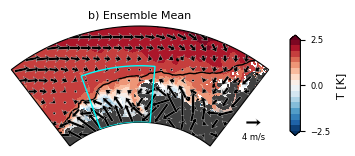

In [11]:
# Plot model domain map 

# parameters
save = True
title = 'b) Ensemble Mean'
data_2d = T_em
data_x, data_y = uwind_em_time_avg, vwind_em_time_avg
vec_len = 4
levs = np.linspace(-2.5,2.5,17)
cmap = 'RdBu_r'

# Set up plot
projection = ccrs.SouthPolarStereo(central_longitude=-100)
lons, lats = data_2d.lon, data_2d.lat
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((4,1.5))
plt.title(title, fontsize=8)
plt.gca().set_axis_off()

# Plot color data
ax = fig.add_subplot(projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
data_2d_ma = data_2d.where(data_2d != 0)
cf_em = ax.contourf(lons, lats, data_2d_ma,transform=grid_proj,
                    levels=levs, cmap='RdBu_r', zorder=0, extend = 'both')

# Plot quiver data
q_lon,q_lat = data_x.lon.values, data_x.lat.values
quiv = ax.quiver(q_lon,q_lat, data_x.values, data_y.values,
                 transform = grid_proj, regrid_shape=12,
                 pivot = 'middle', scale=70, width=0.01,
                 headlength=2, headaxislength=1.5, minshaft=.5,
                 edgecolor='white', linewidth = 0.2,zorder=3)
ax.quiverkey(quiv, X=0.94, Y=0.2, U=vec_len, label=str(vec_len)+' m/s', 
             fontproperties={'size': 6}, labelpos='S')

# Add colorbar 
cb_ax = fig.add_axes([0.9,0.12,0.026,0.67])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'vertical')  
cb_em.set_label('T [K]', fontsize=8)
cb_em.ax.tick_params(labelsize=6)
cb_em.set_ticks([levs[0],0,levs[-1]])

# Plot bathyemtry and ice locations in all subplots, and format map extent
land_ice_ds = fda.get_bathymetry_and_troughs()
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (1000,)

# Plot bathymetry and ice
ax.contour(lons,lats,land_ice_ds.bathy, blevs, colors='k', transform=grid_proj,
           linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds.all_ice, transform=grid_proj, colors=['lightgray']*2,
            alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds.grounded_ice, transform=grid_proj, cmap='binary_r',
            zorder=2)


# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], 
                   [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

# Add box for AS near
lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near'] # -65.5,-76.5,-140,-65.1
lons_arc = np.linspace(lon1, lon2, 100)
lats_arc = np.full_like(lons_arc, lat2)
lons_back = np.linspace(lon2, lon1, 100)
lats_back = np.full_like(lons_back, lat1)
lons_left = np.full_like(lons_arc, lon1)
lats_left = np.linspace(lat1, lat2, 100)
lons = np.concatenate([lons_arc, lons_back, lons_left])
lats = np.concatenate([lats_arc, lats_back, lats_left])
vertices_proj = projection.transform_points(ccrs.PlateCarree(), lons, lats)
codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices_proj) - 1)
path = Path(vertices_proj[:, :2], codes)
patch = PathPatch(path, facecolor='none', edgecolor='cyan', linewidth=1, zorder=4)
ax.add_patch(patch)

fig.subplots_adjust(left=0.2,right=0.85,top=0.85,bottom=0.05,wspace=0.1,hspace=.05)

if save:
    save_name = 'Plots/Figure_1b_ens_mean_wind_map.png'
    plt.savefig(save_name, bbox_inches='tight', dpi=400)
    print('Saving figure as',save_name)